In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from pathlib import Path
# train_audio_path=Path(r'D:\speech recognition\greek_dataset_phylology_dept') #GREEK DATASET
train_audio_path = Path(r'D:\speech recognition\train\audio') #ENGLISH DATASET
import librosa.display
from scipy.io import wavfile
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
SAMPLE_RATE=16000

Preprocessing

In [62]:
##preprocessing and feature extraction
tamikimeta=[]
def create_df(path): #LOADING ENGLISH DATA
    tmp_list=[]
    for dirpath, dirnames, filenames  in (os.walk(path)) :
        if dirpath != os.path.join(path, "_background_noise_" ) and  dirpath is not path :  
            # print(dirpath)
            for file in filenames:
                if file.endswith('.wav'):
                    tmp_path=os.path.join(dirpath, file)
                    class_label = tmp_path.split('\\')[-2] 
                    tmp_list.append([tmp_path,class_label])
                else:
                    continue
    return  pd.DataFrame(tmp_list,columns=['file_path','word_label'])


# def create_df(path): #LOADING GREEK DATA
#     tmp_list=[]
#     files = [f for f in os.listdir(str(train_audio_path)) if f.endswith('.wav')]
#     for file in files:
#         if file.endswith('.wav'):
#             tmp_path=os.path.join(path, file)
#             word_label= file.split('_')[-2]
#             tmp_list.append([tmp_path,word_label])
#         else:
#             continue
#     return  pd.DataFrame(tmp_list,columns=['file_path','word_label']) #dataframe containing the path for each word

def findmaxlength(audio_path,lengths): #FUNCTION WHICH FINDS THE TIMESERIES WITH THE MOST SAMPLES

    data,samplerate = librosa.load(audio_path,SAMPLE_RATE)
    #lengths.append(librosa.get_duration(y=data,sr=samplerate)) #list containing the length of each audio
    lengths.append(len(data))
    
    return lengths

def extract_feat(data,sr): #FEATURE EXTRACTION AND STACKING TO AN ARRAY
    image_w_features = np.array([])

    mfcc = librosa.feature.mfcc(data,sr=sr,n_mfcc=13,n_fft=2048,hop_length=512).T
                    
    zcr=librosa.feature.zero_crossing_rate(data, frame_length=2048, hop_length=512, center=True).T
    
    spectral_roloff=librosa.feature.spectral_rolloff(data, sr=sr,n_fft=2048, hop_length=512,center=True).T
    
    chromagram = librosa.feature.chroma_stft(data, sr=sr, hop_length=512).T
    
    spec_bw = librosa.feature.spectral_bandwidth(y=data, sr=sr,hop_length=512,n_fft=2048, center=True).T

    image_w_features=np.hstack((mfcc,zcr))

    image_w_features=np.hstack((image_w_features,spectral_roloff))
    image_w_features=np.hstack((image_w_features,chromagram))
    image_w_features=np.hstack((image_w_features,spec_bw))
 
    return image_w_features

def get_feat_padded(audio_path,megistomikos): #ZERO PADDING FOR EQUAL LENGTH TIMESERIES

    data,samplerate = librosa.load(audio_path,SAMPLE_RATE)
    
    if len(data)<megistomikos:
        poso=int((megistomikos-len(data))/2)
        data=np.pad(data, pad_width=(poso, poso), mode='constant')
    
    #ta miki

    tamikimeta.append(len(data))
    feat = extract_feat(data,SAMPLE_RATE)
    image_feat = np.array(feat)

    return image_feat

lengths=[]
X, Y, paths = [], [], []

speech_dataframe=create_df(train_audio_path)
speech_dataframe = speech_dataframe.sample(frac = 1) #shuffling dataframe rows
# speech_dataframe=speech_dataframe.groupby('word_label').apply(lambda x: x.sample(300))
for path in speech_dataframe.file_path:
    miki= findmaxlength(path,lengths)
    
maxmikos=max(miki)
print(maxmikos)

for path, word in zip(speech_dataframe.file_path, speech_dataframe.word_label): #CREATE FEATURE AND CATEGORY VECTORS

    features=get_feat_padded(path,maxmikos)
    X.append(features)
    Y.append(word) 
    paths.append(path)

tameta=np.array(tamikimeta)        
plt.hist(tameta)

C:\Users\adrea\AppData\Local\Temp\ipykernel_20340\3585772569.py:30: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data,samplerate = librosa.load(audio_path,SAMPLE_RATE)


Scaling and encoding

In [ ]:
scaler = StandardScaler()
X=np.array(X)
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
print("padded and scaled features ",X.shape)
#encoding the labels 
print("label ",Y[0])

le = LabelEncoder()
Y = to_categorical(le.fit_transform(Y)) 
print("encoded label ",Y[0])

Train,test,validation split and CNN model training

In [58]:
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping
keras.backend.clear_session()

#creating test and validation set

X_train, X_test, Y_train, Y_test, train_paths, test_paths = train_test_split(X,Y,paths,test_size=0.20)
X_test, X_validation, Y_test, Y_validation, test_paths, validation_paths = train_test_split(X_test,Y_test, test_paths,test_size=0.50)

#3D->4D array for input of CNN
print(X_train.shape,X_test.shape,X_validation.shape)
X_train=X_train[..., np.newaxis]
X_validation=X_validation[..., np.newaxis]
X_test=X_test[..., np.newaxis]

#building model
input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3])
print(input_shape)
cnnModel=keras.Sequential()


cnnModel.add(keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape))#32
cnnModel.add(keras.layers.MaxPooling2D((3,3), strides=(2,2),padding='same'))
cnnModel.add(keras.layers.BatchNormalization())

cnnModel.add(keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape))
cnnModel.add(keras.layers.MaxPooling2D((3,3), strides=(2,2),padding='same'))
cnnModel.add(keras.layers.BatchNormalization())
            
cnnModel.add(keras.layers.Conv2D(32,(2,2),activation='relu',input_shape=input_shape))#22
cnnModel.add(keras.layers.MaxPooling2D((2,2), strides=(2,2),padding='same'))
cnnModel.add(keras.layers.BatchNormalization())
            
             
#flatten the output and dense layers
cnnModel.add(keras.layers.Flatten())
cnnModel.add(keras.layers.Dense(64,activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
cnnModel.add(keras.layers.Dropout(0.3))
#cnnModel.add(keras.layers.Dense(64,activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
#cnnModel.add(keras.layers.Dropout(0.3))
             
#ouput layer
cnnModel.add(keras.layers.Dense(50,activation='softmax'))
             
optimiz = keras.optimizers.Adam(0.0001)
cnnModel.compile(optimizer=optimiz,loss="categorical_crossentropy",metrics=["accuracy"])             
cnnModel.summary()         

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='auto', restore_best_weights=True)

historyConv=cnnModel.fit(X_train,Y_train,validation_data=(X_validation,Y_validation),callbacks=[monitor],batch_size=32,epochs=200)

test_error,test_accuracy=cnnModel.evaluate(X_test,Y_test,verbose=1)  
print("Accuracy on test set is {}".format(test_accuracy))            
print("Error on test set is {}".format(test_error))                  

(39, 28, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 37, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 13, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 19, 13, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 11, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 6, 32)         0         
 2D)                                                             
                                            

69/69 [==============================] - 0s 7ms/step - loss: 1.3431 - accuracy: 0.6195
Test accuracy: 61.9505%


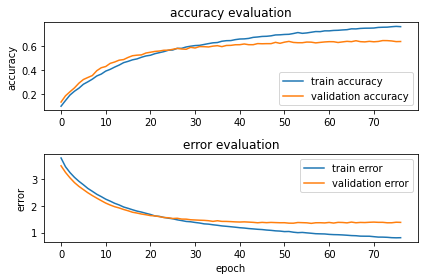

In [54]:
##accuracy and error diagrams 
score = cnnModel.evaluate(X_test,Y_test,verbose=1)
accuracy = 100*score[1]

print("Test accuracy: %.4f%%" % accuracy) 

fig,axs= plt.subplots(2)

axs[0].plot(historyConv.history["accuracy"], label="train accuracy")
axs[0].plot(historyConv.history["val_accuracy"], label="validation accuracy")
axs[0].set_ylabel("accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("accuracy evaluation")


axs[1].plot(historyConv.history["loss"], label="train error")
axs[1].plot(historyConv.history["val_loss"], label="validation error")
axs[1].set_ylabel("error")
axs[1].set_xlabel("epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("error evaluation")

plt.tight_layout()
plt.show()

Create feature vectors using the trained CNN 

450/450 [==============================] - 1s 2ms/step
[0.0752944  0.04096487]


<function matplotlib.pyplot.show(close=None, block=None)>

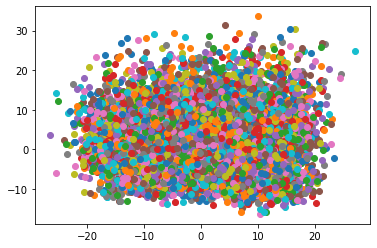

In [39]:
from sklearn.decomposition import PCA

num_components = 2
model = keras.Model(inputs=cnnModel.inputs, outputs=cnnModel.layers[8].output)
encoded_feats = model.predict(X_test) # create feature vectors for all input data
embeddings = [np.ravel(e) for e in encoded_feats] #flatten encoded features
pca = PCA(n_components=num_components)
pca.fit(embeddings)
pca_proj = pca.transform(embeddings)
print(pca.explained_variance_ratio_)
fig = plt.figure()
ax = fig.add_subplot()
for pca in pca_proj:
    ax.scatter(pca[0], pca[1])
plt.show

Calculate cosine similarity for the feature vectors

In [40]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(embeddings)

450/450 [==============================] - 1s 2ms/step


Create similarity database using dictionary

In [42]:
similarity_database = {}
for P, S in zip(test_paths, similarity_matrix):
    similarity_database[P] = S

Function for indexing feature vectors, that returns n most similar speech commands

In [35]:
def get_similar_audio(path, similarity_database, n_results):
    """
    Retrieve n_results most similar audio files to the given audio file at path from the given similarity_database
    """
    n_results += 1
    all_paths = list(similarity_database.keys())
    # ipd.display(ipd.Audio(path))
    # get similarity results for this audio
    similar = similarity_database[path]
    # get indexes of n_results highest values
    result_indexes = np.argpartition(similar, -n_results)[-n_results:]
    # build dictionary from results of paths and similarity scores
    results = {k:v for (k,v) in zip([all_paths[x] for x in result_indexes], [similar[x] for x in result_indexes])}
    # eliminate self from results
    results = {k:v for k, v in results.items() if k != path}
    # get keys for results by value in reverse sorted order
    sorted_keys = sorted(results, key=results.__getitem__, reverse=True)
    
    #show results
    count = 1
    for k in sorted_keys:
        print(f'Result {count}: {k}, Similarity: {results[k]:.3f}')
        # ipd.display(ipd.Audio(k))
        count += 1

In [44]:
import random
# test returning results and check playback
n_examples = 5
n_results = 5
for i in range(n_examples):
    path = test_paths[random.randint(0, len(Y_test))] # select a random path from all_paths
    print(f'Finding similar sounds to {path}')
    get_similar_audio(path, similarity_database, n_results)
    print('\n\n-----------------------------------------------------------\n\n')

Finding similar sounds to D:\speech recognition\train\audio\bird\61a9f72a_nohash_1.wav
Result 1: D:\speech recognition\train\audio\bird\6a014b29_nohash_1.wav, Similarity: 0.488
Result 2: D:\speech recognition\train\audio\bird\50d1c8e3_nohash_0.wav, Similarity: 0.483
Result 3: D:\speech recognition\train\audio\bird\7f74626f_nohash_0.wav, Similarity: 0.463
Result 4: D:\speech recognition\train\audio\one\fb7cfe0e_nohash_2.wav, Similarity: 0.456
Result 5: D:\speech recognition\train\audio\bird\5c39594f_nohash_0.wav, Similarity: 0.453


-----------------------------------------------------------


Finding similar sounds to D:\speech recognition\train\audio\dog\5e3dde6b_nohash_0.wav
Result 1: D:\speech recognition\train\audio\dog\070b49af_nohash_1.wav, Similarity: 0.427
Result 2: D:\speech recognition\train\audio\down\7ea032f3_nohash_0.wav, Similarity: 0.409
Result 3: D:\speech recognition\train\audio\up\3c257192_nohash_4.wav, Similarity: 0.409
Result 4: D:\speech recognition\train\audio\dog